In [1]:
# Install necessary packages
!pip3 install torch
!pip3 install torchvision
!pip3 install torchaudio

     |████████████████████████████████| 3.2MB 2.8MB/s 


In [2]:
# import necessary packages
import torch, torchvision, torchaudio
from torch.utils.data import DataLoader, Dataset

In [3]:
# clone the dataset from github
!git clone https://github.com/Dimbinantenaina/Malagasy_Speech_Data.git

Cloning into 'Malagasy_Speech_Data'...
remote: Enumerating objects: 5833, done.
remote: Total 5833 (delta 0), reused 0 (delta 0), pack-reused 5833
Receiving objects: 100% (5833/5833), 347.26 MiB | 37.07 MiB/s, done.
Resolving deltas: 100% (2891/2891), done.
Checking out files: 100% (8508/8508), done.


In [11]:
import os
from typing import Tuple

import torchaudio
from torch import Tensor
from torch.utils.data import Dataset
from torchaudio.datasets.utils import (
  download_url,
  extract_archive,
  walk_files,
          )


def load_mg_item(  transcription: str,
                          k: int,
                 path : str = '/content/Malagasy_Speech_Data/mlg_data/mlg_audios/'
                          )-> Tuple[Tensor, int, str]:
  '''
  load the audio files and combine each with their transcriptions
  '''
  file_text = transcription
  
  with open(file_text) as ft:
    f = ft.read().split('\n')[:-1]
    f = f[k].split(', ')
    fileid_audio = f[0]
    utterance = f[1]
  
  waveform, sample_rate = torchaudio.load(path + fileid_audio)

  return (waveform,  sample_rate, utterance)


class MALAGASY(Dataset):
  """
  Create a Dataset module for Malgasy_Speech_Data. Each item is a tuple of the form:
  waveform, sample_rate, utterance
  """

  _ext_txt = ".txt"
  _ext_audio = ".wav"

  def __init__(self,
        path : str = '/content/Malagasy_Speech_Data/mlg_data/'
        ) -> None:
    self._path = path 

    walker = walk_files(
     self._path, suffix=self._ext_audio, prefix=False, remove_suffix=True
    )
    self._walker = list(walker)

  def __getitem__(self, k):
    return load_mg_item(self._path + 'transcriptions.txt',k)

  def __len__(self) -> int:
    return len(self._walker) 


In [12]:
# Define the list of tokens used in the transcriptions
tokens_list = list(" 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZÀÁÃÂÆÇÉÈÊËÏÎÍÌÔÒŒÙÛÜŸÝ%€$+–-*/=@~→“”…")
tokens_set = set(tokens_list)

In [13]:
def collate_fn_mg(batch):
  #print(batch)
  tensors = [b[0].t() for b in batch if b]
  tensors_len = [len(t) for t in tensors]
  tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
  tensors = tensors.transpose(1, -1)
  
  transcriptions = [list(b[-1].replace("'", " ").replace('[', ' ')) for b in batch if b]
  targets = [torch.tensor([tokens_list.index(e) for e in t]) for t in transcriptions]
  targets_len = [len(t) for t in targets]
  targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

  return tensors, targets, torch.tensor(tensors_len), torch.tensor(targets_len)

In [14]:
ds = MALAGASY() # change the path to the location of the data if needed

In [15]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
validation_split = .25
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(ds)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]


# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(ds, batch_size=8,
                                             sampler=train_sampler,  num_workers=4, collate_fn= collate_fn_mg)
valid_loader = torch.utils.data.DataLoader(ds, batch_size=8,
                                             sampler=valid_sampler, num_workers=4, collate_fn= collate_fn_mg)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [17]:
# print the first instance of the dataset
for x, y,x_len, y_len in train_loader:
  print(y)
  break

tensor([[24, 15, 16, 11,  0, 30, 29, 35,  0, 24, 11, 32, 15, 22, 11, 24, 35,  0,
         18, 11, 24, 14, 15, 18, 11,  0, 16, 19, 11, 28, 11,  0, 24, 35,  0, 23,
         11, 22, 11, 17, 11, 29, 35,  0, 15, 30, 25,  0, 11, 24, 64, 30, 25, 15,
         28, 11, 24, 11,  0, 30, 25, 21, 25, 24, 35,  0, 18, 25, 14, 35,  0, 11,
         24, 35,  0, 11, 23, 19, 24,  0, 24, 35,  0, 16, 11, 28, 19, 30, 28, 11,
          0, 23, 19, 29, 35,  0, 11, 36, 35,  0, 11, 32, 35,  0],
        [19, 28, 15, 25,  0, 16, 11, 24, 20, 11, 21, 11, 24,  0, 24, 35,  0, 12,
         15, 36, 11, 24, 25, 36, 11, 24, 25,  0, 30, 11, 25,  0, 11, 30, 29, 19,
         24, 11, 24, 11, 24, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [28, 11, 18, 11,  0, 24, 35,  0, 11, 23, 19, 24, 3

In [18]:
# get the maximum number of characters in the transcriptions
N_CHARS = 0
for x in train_loader:
  b = x[-1].max()  
  if b > N_CHARS:
    N_CHARS = b
N_CHARS = N_CHARS.item()

In [20]:
# display one audio instance
import IPython
IPython.display.Audio("/content/Malagasy_Speech_Data/mlg_data/mlg_audios/200630-101824_mlg_7f0_elicit_9.wav", rate=16000)

In [ ]:
# Download the pretrained models
!mkdir checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt -P checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json -P checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_args.json -P checkpoint_data
!ls checkpoint_data

mkdir: cannot create directory ‘checkpoint_data’: File exists
--2020-07-05 21:08:50--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113599715 (108M) [application/octet-stream]
Saving to: ‘checkpoint_data/checkpoint_30.pt.3’

checkpoint_30.pt.3  100%[===================>] 108.34M  35.7MB/s    in 3.0s    

2020-07-05 21:08:54 (35.7 MB/s) - ‘checkpoint_data/checkpoint_30.pt.3’ saved [113599715/113599715]

--2020-07-05 21:08:55--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.f

In [ ]:
# clone the CPC_audio tools
! git clone https://github.com/facebookresearch/CPC_audio.git  #

fatal: destination path 'CPC_audio' already exists and is not an empty directory.


In [ ]:
!pip install soundfile

In [ ]:
%cd /content/CPC_audio
from cpc.dataset import parseSeqLabels
from cpc.feature_loader import loadModel
# Define the cpc_model
checkpoint_path = '/content/checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
cpc_model = cpc_model.cuda()

/content/CPC_audio
Loading checkpoint /content/checkpoint_data/checkpoint_30.pt
Loading the state dict at /content/checkpoint_data/checkpoint_30.pt


In [ ]:
class PhoneClassifier(torch.nn.Module):

  def __init__(self,
               input_dim : int,
               n_phones : int,
               n_hidden = 2,
               hidden_dim = 2000):
    super(PhoneClassifier, self).__init__()
    module_list = [torch.nn.Linear(input_dim, hidden_dim)]

    for i in range(n_hidden):
        module_list.append(torch.nn.Linear(hidden_dim, hidden_dim))

    module_list.append(torch.nn.Linear(hidden_dim, n_phones))

    self.layers = torch.nn.ModuleList(module_list)                       
                                       
  def forward(self, x):
    for modul in self.layers:
      x = modul(x)
    return x

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
phone_classifier = PhoneClassifier(HIDDEN_CONTEXT_MODEL, N_PHONES).to(device)

In [ ]:
loss_ctc = torch.nn.CTCLoss()
parameters = list(phone_classifier.parameters()) + list(cpc_model.parameters())
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)

optimizer_frozen = torch.optim.Adam(list(phone_classifier.parameters()), lr=LEARNING_RATE)

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def train_one_epoch_ctc(cpc_model, 
                        phone_classifier, 
                        loss_criterion, 
                        data_loader, 
                        optimizer):
  
  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):

    x, y, x_len, y_len = full_data

    x_batch_len = x.shape[-1]
    x, y = x.to(device), y.to(device)

    bs=x.size(0)
    optimizer.zero_grad()
    context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
  
    scores = phone_classifier(context_out)
    scores = scores.permute(1,0,2)
    scores = F.log_softmax(scores,2)
    yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

    loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
  avg_loss/=n_items
  return avg_loss

def validation_step(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader):

  cpc_model.eval()
  phone_classifier.eval()
  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):

      x, y, x_len, y_len = full_data

      x_batch_len = x.shape[-1]
      x, y = x.to(device), y.to(device)

      bs=x.size(0)
      context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
    
      scores = phone_classifier(context_out)
      scores = scores.permute(1,0,2)
      scores = F.log_softmax(scores,2)
      yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

      loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
      avg_loss+=loss.item()*bs
      n_items+=bs
  avg_loss/=n_items

  return avg_loss

def run_ctc(cpc_model, 
            phone_classifier, 
            loss_criterion, 
            data_loader_train, 
            data_loader_val, 
            optimizer,
            n_epoch):
  train_losses = []
  valid_losses = []
  for epoch in range(n_epoch):

    print(f"Running epoch {epoch + 1} / {n_epoch}")
    loss_train = train_one_epoch_ctc(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer)
    print("-------------------")
    print(f"Training dataset :")
    print(f"Average loss : {loss_train}.")
    train_losses.append(loss_train)

    print("-------------------")
    print("Validation dataset")
    loss_val = validation_step(cpc_model, phone_classifier, loss_criterion, data_loader_val)
    print(f"Average loss : {loss_val}")
    print("-------------------")
    print()
    valid_losses.append(loss_val)
  # plot the progresses
  fig, ax = plt.subplots() 
  ax.plot(np.array(train_losses), label='Training loss')  
  ax.plot(np.array(valid_losses),  label='Validation loss') 
  ax.legend(['Train', 'validation'])  
  plt.show()


Running epoch 1 / 100
-------------------
Training dataset :
Average loss : 2.6285746414259603.
-------------------
Validation dataset
Average loss : 1.3179500182933084
-------------------

Running epoch 2 / 100
-------------------
Training dataset :
Average loss : 1.0996265159815826.
-------------------
Validation dataset
Average loss : 0.8526976325769119
-------------------

Running epoch 3 / 100
-------------------
Training dataset :
Average loss : 0.7978198752928961.
-------------------
Validation dataset
Average loss : 0.732686586004652
-------------------

Running epoch 4 / 100
-------------------
Training dataset :
Average loss : 0.6905684220437693.
-------------------
Validation dataset
Average loss : 1.0626054472200377
-------------------

Running epoch 5 / 100
-------------------
Training dataset :
Average loss : 0.6449757970149451.
-------------------
Validation dataset
Average loss : 0.6478572198496616
-------------------

Running epoch 6 / 100
-------------------
Training 

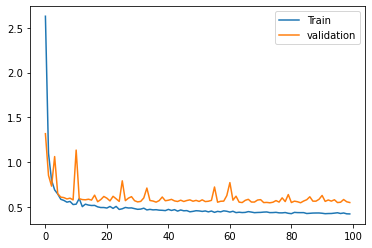

N/A% (0 of 86) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (86 of 86) |########################| Elapsed Time: 0:10:09 Time:  0:10:09


Average CER 0.8967188309034938


0.8967188309034938

In [ ]:
run_ctc(cpc_model,phone_classifier,loss_ctc,train_loader, valid_loader,optimizer_frozen,n_epoch=100)
get_cer(valid_loader,cpc_model, phone_classifier)

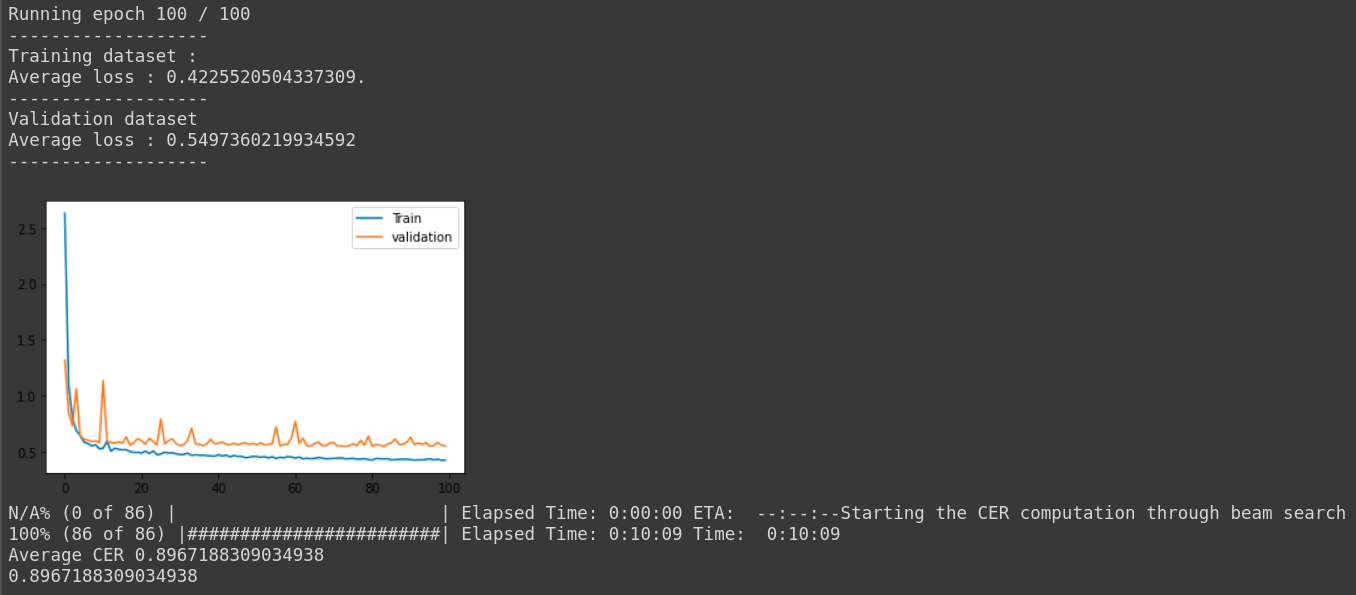

In [ ]:
import numpy as np

def get_CER_sequence(ref_seq, target_seq):
  n = len(ref_seq)
  m = len(target_seq)

  D = np.zeros((n+1,m+1))
  for i in range(1,n+1):
    D[i,0] = D[i-1,0]+1
  for j in range(1,m+1):
    D[0,j] = D[0,j-1]+1
  
  for i in range(1,n+1):
    for j in range(1,m+1):
      D[i,j] = min(
          D[i-1,j]+1,
          D[i-1,j-1]+1,
          D[i,j-1]+1,
          D[i-1,j-1]+ 0 if ref_seq[i-1]==target_seq[j-1] else float("inf")
      )
  return D[n,m]/len(ref_seq)
  

In [ ]:
import progressbar
from multiprocessing import Pool

def cut_data(seq, sizeSeq):
    maxSeq = sizeSeq.max()
    return seq[:, :maxSeq]

def prepare_data(data):
    seq, phone, sizeSeq, sizePhone = data
    seq = seq.cuda()
    phone = phone.cuda()
    sizeSeq = sizeSeq.cuda().view(-1)
    sizePhone = sizePhone.cuda().view(-1)

    seq = cut_data(seq.permute(0, 2, 1), sizeSeq).permute(0, 2, 1)
    return seq, sizeSeq, phone, sizePhone

def get_cer(test_dataloader,
            cpc_model,
            phone_classifier):

  downsampling_factor = 160
  cpc_model.eval()
  phone_classifier.eval()

  avgPER = 0
  nItems = 0 

  print("Starting the CER computation through beam search")
  bar = progressbar.ProgressBar(maxval=len(test_dataloader))
  bar.start()

  for index, data in enumerate(test_dataloader):

    bar.update(index)

    with torch.no_grad():
      
        seq, sizeSeq, phone, sizePhone = prepare_data(data)
        c_feature, _, _ = cpc_model(seq.to(device),phone.to(device))
        sizeSeq = sizeSeq / downsampling_factor
        predictions = torch.nn.functional.softmax(
            phone_classifier(c_feature), dim=2).cpu()
        phone = phone.cpu()
        sizeSeq = sizeSeq.cpu()
        sizePhone = sizePhone.cpu()

        bs = c_feature.size(0)
        data_per = [(predictions[b].argmax(1),  phone[b]) for b in range(bs)]
       
        with Pool(bs) as p:
            poolData = p.starmap(get_CER_sequence, data_per)
        avgPER += sum([x for x in poolData])
        nItems += len(poolData)

  bar.finish()

  avgPER /= nItems

  print(f"Average CER {avgPER}")
  return avgPER

In [ ]:
get_cer(valid_loader,cpc_model, phone_classifier)

N/A% (0 of 86) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the CER computation through beam search


100% (86 of 86) |########################| Elapsed Time: 0:10:13 Time:  0:10:13


Average CER 0.894778998867456


0.894778998867456